In [1]:
import os
import tarfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint
from six.moves import urllib
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor

#matplotlib.use("Agg")
# Suppress warnings from scikit-learn
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import os
import tarfile
import warnings

import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import randint
from six.moves import urllib
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor

matplotlib.use("Agg")
# Suppress warnings from scikit-learn
warnings.filterwarnings("ignore", category=DeprecationWarning)


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path, filter="data")
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


dataset = fetch_housing_data()
housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(strat_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()
compare_props["Rand. %error"] = (
    100 * compare_props["Random"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


corr_matrix = housing.drop(columns="ocean_proximity").corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

housing = strat_train_set.drop(
    "median_house_value", axis=1
)  # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

housing_num = housing.drop("ocean_proximity", axis=1)
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr["rooms_per_household"] = housing_tr["total_rooms"] / housing_tr["households"]
housing_tr["bedrooms_per_room"] = housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
housing_tr["population_per_household"] = (
    housing_tr["population"] / housing_tr["households"]
)

housing_cat = housing[["ocean_proximity"]]
housing_prepared = housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(
    forest_reg,
    param_distributions=param_distribs,
    n_iter=10,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
)
rnd_search.fit(housing_prepared, housing_labels)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, housing_prepared.columns), reverse=True)


final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_num = X_test.drop("ocean_proximity", axis=1)
X_test_prepared = imputer.transform(X_test_num)
X_test_prepared = pd.DataFrame(
    X_test_prepared, columns=X_test_num.columns, index=X_test.index
)
X_test_prepared["rooms_per_household"] = (
    X_test_prepared["total_rooms"] / X_test_prepared["households"]
)
X_test_prepared["bedrooms_per_room"] = (
    X_test_prepared["total_bedrooms"] / X_test_prepared["total_rooms"]
)
X_test_prepared["population_per_household"] = (
    X_test_prepared["population"] / X_test_prepared["households"]
)

X_test_cat = X_test[["ocean_proximity"]]
X_test_prepared = X_test_prepared.join(pd.get_dummies(X_test_cat, drop_first=True))


final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path, filter="data")
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

dataset = fetch_housing_data()
housing = load_housing_data()

(array([ 822.,    0., 6581.,    0.,    0., 7236.,    0., 3639.,    0.,
        2362.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

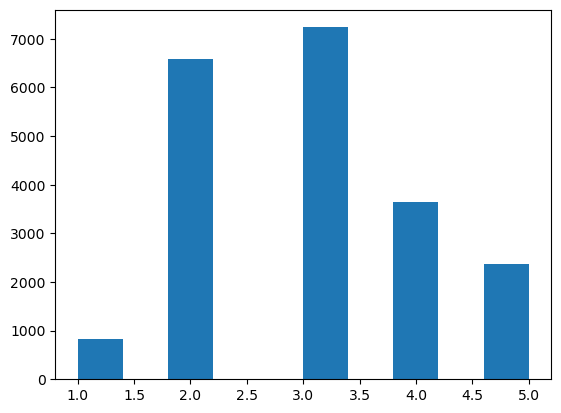

In [3]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)
plt.hist(housing["income_cat"])

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)

In [5]:
for train_index,test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [6]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

In [7]:
round(income_cat_proportions(strat_train_set)*100)

income_cat
3    35.0
2    32.0
4    18.0
5    11.0
1     4.0
Name: count, dtype: float64

In [8]:
round(income_cat_proportions(strat_test_set) * 100)

income_cat
3    35.0
2    32.0
4    18.0
5    11.0
1     4.0
Name: count, dtype: float64

In [ ]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


In [10]:
compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(strat_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()
compare_props["Rand. %error"] = (
    100 * compare_props["Random"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


<Axes: xlabel='longitude', ylabel='latitude'>

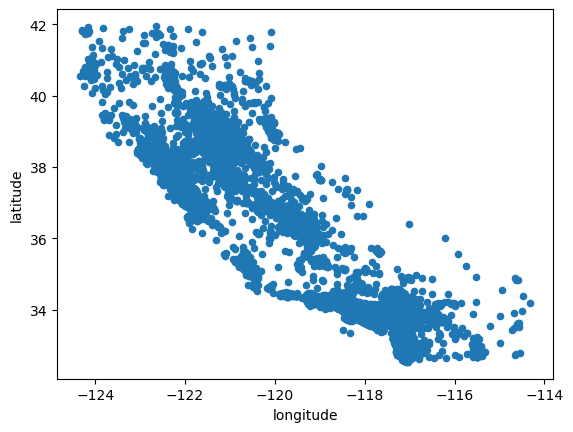

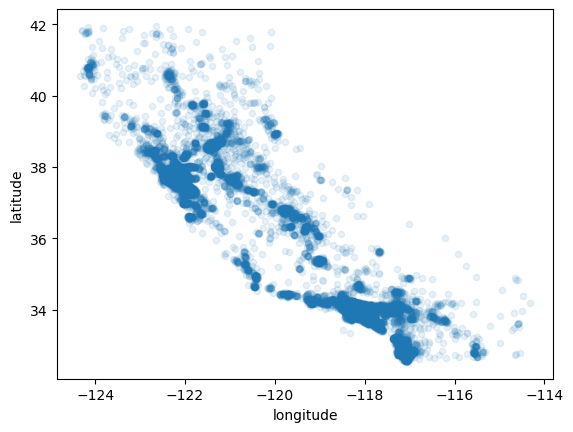

In [11]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


In [12]:
corr_matrix = housing.drop(columns="ocean_proximity").corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466,-0.016281
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673,-0.078768
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146,-0.139314
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140,0.221745
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781,0.012635
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882,0.022900
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590,0.035115
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151,0.902151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000,0.642256
income_cat,-0.016281,-0.078768,-0.139314,0.221745,0.012635,0.022900,0.035115,0.902151,0.642256,1.000000


In [13]:
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.687151
income_cat            0.642256
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [14]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]


In [15]:
housing = strat_train_set.drop("median_house_value", axis=1)

In [17]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat'],
      dtype='object')

In [16]:
housing_labels = strat_train_set["median_house_value"].copy()
housing_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

In [18]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [23]:
housing_num.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
income_cat              0
dtype: int64

In [26]:
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
X = imputer.transform(housing_num)


In [27]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,2.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,5.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,2.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,2.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,3.0
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,4.0
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,2.0
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,3.0
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,3.0


In [29]:
housing_tr.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
income_cat            0
dtype: int64

In [30]:
housing_tr["rooms_per_household"] = housing_tr["total_rooms"] / housing_tr["households"]
housing_tr["bedrooms_per_room"] = housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
housing_tr["population_per_household"] = (
    housing_tr["population"] / housing_tr["households"]
)

In [34]:
housing_cat = housing[["ocean_proximity"]]
housing_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


In [35]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7277
INLAND             5262
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
Name: count, dtype: int64

In [36]:
pd.get_dummies(housing_cat, drop_first=True)

,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,True,False,False,False
15502,False,False,False,True
2908,True,False,False,False
14053,False,False,False,True
20496,False,False,False,False
...,...,...,...,...
15174,False,False,False,False
12661,True,False,False,False
19263,False,False,False,False
19140,False,False,False,False


In [42]:
strat_train_set.shape

(16512, 11)

In [43]:
strat_test_set.shape

(4128, 11)

In [38]:
housing_prepared = housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))
housing_prepared.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,2.0,5.485836,0.205784,3.168555,True,False,False,False
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,5.0,6.927083,0.160714,2.623698,False,False,False,True
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,2.0,5.393333,0.191595,2.223333,True,False,False,False


In [39]:
housing_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

In [44]:
housing_prepared.shape

(16512, 16)

In [50]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

y_train_pred = lin_reg.predict((housing_prepared))
lin_mse = mean_squared_error(housing_labels, y_train_pred)
lin_mae = mean_absolute_error(housing_labels, y_train_pred)
lin_rmse = np.sqrt(lin_mse)
lin_mae,lin_rmse

(49507.342337760885, np.float64(68376.51254853733))

In [51]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mae = mean_absolute_error(housing_labels,housing_predictions)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mae,tree_rmse

(0.0, np.float64(0.0))

In [52]:
param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}
param_distribs

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fd9a85e6900>,
 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fd9a85e4d70>}

In [54]:
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(
    forest_reg,
    param_distributions=param_distribs,
    n_iter=10,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
)
rnd_search

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd9a85e4d70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd9a85e6900>},
                   random_state=42, scoring='neg_mean_squared_error')

In [55]:
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd9a85e4d70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd9a85e6900>},
                   random_state=42, scoring='neg_mean_squared_error')

In [59]:
cvres = rnd_search.cv_results_
cvres["params"], cvres["mean_test_score"]

([{'max_features': 7, 'n_estimators': 180},
  {'max_features': 5, 'n_estimators': 15},
  {'max_features': 3, 'n_estimators': 72},
  {'max_features': 5, 'n_estimators': 21},
  {'max_features': 7, 'n_estimators': 122},
  {'max_features': 3, 'n_estimators': 75},
  {'max_features': 3, 'n_estimators': 88},
  {'max_features': 5, 'n_estimators': 100},
  {'max_features': 3, 'n_estimators': 150},
  {'max_features': 5, 'n_estimators': 2}],
 array([-2.51166183e+09, -2.70846633e+09, -2.65255887e+09, -2.64364266e+09,
        -2.51536700e+09, -2.65039763e+09, -2.63907730e+09, -2.53017159e+09,
        -2.62060041e+09, -4.27223753e+09]))

In [60]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50116.48259976167 {'max_features': 7, 'n_estimators': 180}
52042.92780224809 {'max_features': 5, 'n_estimators': 15}
51502.99864777071 {'max_features': 3, 'n_estimators': 72}
51416.365646565166 {'max_features': 5, 'n_estimators': 21}
50153.43459742913 {'max_features': 7, 'n_estimators': 122}
51482.01266637478 {'max_features': 3, 'n_estimators': 75}
51371.95050589773 {'max_features': 3, 'n_estimators': 88}
50300.811052926234 {'max_features': 5, 'n_estimators': 100}
51191.80025662098 {'max_features': 3, 'n_estimators': 150}
65362.35557961644 {'max_features': 5, 'n_estimators': 2}


In [63]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]
param_grid

[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

In [64]:
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)

In [65]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [66]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [67]:
cvres = grid_search.cv_results_
cvres

{'mean_fit_time': array([0.06261349, 0.1989615 , 0.59725142, 0.09846048, 0.33855901,
        0.96466284, 0.13692975, 0.45233836, 1.34833245, 0.17729068,
        0.57740726, 1.77052145, 0.08402247, 0.27641144, 0.11163216,
        0.36665964, 0.13992877, 0.46937337]),
 'std_fit_time': array([0.00240641, 0.00289466, 0.01242109, 0.00334884, 0.00768929,
        0.00968152, 0.00299238, 0.00397843, 0.00496534, 0.00405875,
        0.00312877, 0.017893  , 0.00193632, 0.00285258, 0.00204972,
        0.00328655, 0.00347782, 0.01167527]),
 'mean_score_time': array([0.00428052, 0.00896688, 0.02190652, 0.00377016, 0.00926995,
        0.02140441, 0.00387182, 0.00814371, 0.0215816 , 0.00372257,
        0.00828509, 0.02320013, 0.00414677, 0.01074076, 0.00433202,
        0.01034446, 0.00442119, 0.01007695]),
 'std_score_time': array([0.00039956, 0.00039803, 0.00105428, 0.00023039, 0.00114889,
        0.00039784, 0.00028534, 0.00030763, 0.00087271, 0.0002536 ,
        0.00022645, 0.00230599, 0.00027911, 

In [ ]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


63817.050199378886 {'max_features': 2, 'n_estimators': 3}
56097.773189178726 {'max_features': 2, 'n_estimators': 10}
53626.15219160384 {'max_features': 2, 'n_estimators': 30}
60427.363793379314 {'max_features': 4, 'n_estimators': 3}
53861.10263125058 {'max_features': 4, 'n_estimators': 10}
51397.120573238 {'max_features': 4, 'n_estimators': 30}
60361.39545001636 {'max_features': 6, 'n_estimators': 3}
53264.65458371887 {'max_features': 6, 'n_estimators': 10}
50819.295214140795 {'max_features': 6, 'n_estimators': 30}
59869.99390962277 {'max_features': 8, 'n_estimators': 3}
53221.399573111754 {'max_features': 8, 'n_estimators': 10}
50885.19087174557 {'max_features': 8, 'n_estimators': 30}
63069.260142479805 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54867.78397645365 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60110.187862837935 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53480.39949831551 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [73]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, housing_prepared.columns), reverse=True)

[(np.float64(0.2620663414758185), 'median_income'),
 (np.float64(0.14257504179420882), 'income_cat'),
 (np.float64(0.1325293848219723), 'ocean_proximity_INLAND'),
 (np.float64(0.11300144438986007), 'population_per_household'),
 (np.float64(0.06177725176159944), 'longitude'),
 (np.float64(0.06070705092882334), 'bedrooms_per_room'),
 (np.float64(0.060163962034121325), 'latitude'),
 (np.float64(0.04632137381730203), 'housing_median_age'),
 (np.float64(0.046258370926786925), 'rooms_per_household'),
 (np.float64(0.017525088082512876), 'population'),
 (np.float64(0.017254647099357857), 'total_rooms'),
 (np.float64(0.01689163211885658), 'total_bedrooms'),
 (np.float64(0.0161132582158218), 'households'),
 (np.float64(0.003974431144780953), 'ocean_proximity_NEAR OCEAN'),
 (np.float64(0.0027815958126089844), 'ocean_proximity_NEAR BAY'),
 (np.float64(5.912557556835725e-05), 'ocean_proximity_ISLAND')]

In [74]:
final_model = grid_search.best_estimator_
final_model

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [76]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [79]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,<1H OCEAN,5
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,<1H OCEAN,4
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,<1H OCEAN,3
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,<1H OCEAN,3
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,NEAR OCEAN,3
...,...,...,...,...,...,...,...,...,...,...
12182,-117.29,33.72,19.0,2248.0,427.0,1207.0,368.0,2.8170,<1H OCEAN,2
7275,-118.24,33.99,33.0,885.0,294.0,1270.0,282.0,2.1615,<1H OCEAN,2
17223,-119.72,34.44,43.0,1781.0,342.0,663.0,358.0,4.7000,<1H OCEAN,4
10786,-117.91,33.63,30.0,2071.0,412.0,1081.0,412.0,4.9125,<1H OCEAN,4


In [81]:
X_test_num = X_test.drop("ocean_proximity", axis=1)
X_test_prepared = imputer.transform(X_test_num)
X_test_prepared = pd.DataFrame(
    X_test_prepared, columns=X_test_num.columns, index=X_test.index
)
X_test_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,5.0
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,4.0
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,3.0
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,3.0
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,3.0
...,...,...,...,...,...,...,...,...,...
12182,-117.29,33.72,19.0,2248.0,427.0,1207.0,368.0,2.8170,2.0
7275,-118.24,33.99,33.0,885.0,294.0,1270.0,282.0,2.1615,2.0
17223,-119.72,34.44,43.0,1781.0,342.0,663.0,358.0,4.7000,4.0
10786,-117.91,33.63,30.0,2071.0,412.0,1081.0,412.0,4.9125,4.0


In [82]:
X_test_prepared["rooms_per_household"] = (
    X_test_prepared["total_rooms"] / X_test_prepared["households"]
)
X_test_prepared["bedrooms_per_room"] = (
    X_test_prepared["total_bedrooms"] / X_test_prepared["total_rooms"]
)
X_test_prepared["population_per_household"] = (
    X_test_prepared["population"] / X_test_prepared["households"]
)

X_test_cat = X_test[["ocean_proximity"]]
X_test_prepared = X_test_prepared.join(pd.get_dummies(X_test_cat, drop_first=True))

In [83]:
X_test_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,5.0,6.715625,0.156972,2.275000,False,False,False,False
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,4.0,7.137809,0.151980,3.021201,False,False,False,False
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,3.0,5.283636,0.185822,2.938182,False,False,False,False
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,3.0,5.491694,0.196612,3.561462,False,False,False,False
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,3.0,6.154723,0.162477,2.434853,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12182,-117.29,33.72,19.0,2248.0,427.0,1207.0,368.0,2.8170,2.0,6.108696,0.189947,3.279891,False,False,False,False
7275,-118.24,33.99,33.0,885.0,294.0,1270.0,282.0,2.1615,2.0,3.138298,0.332203,4.503546,False,False,False,False
17223,-119.72,34.44,43.0,1781.0,342.0,663.0,358.0,4.7000,4.0,4.974860,0.192027,1.851955,False,False,False,False
10786,-117.91,33.63,30.0,2071.0,412.0,1081.0,412.0,4.9125,4.0,5.026699,0.198938,2.623786,False,False,False,False


In [84]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(48839.01403510785)

In [ ]:
# Ingest data
# preprocessing
# prepare model data
# train
# score

In [5]:
import os

In [ ]:
os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

In [ ]:
from src.data.ingest_data import fetch_data, load_data
from src.data.preprocessing import preprocess_df, add_features
from src.data.prepare_model_data import train_test_split
from src.data.train import train_linear,train_decision_tree,train_forest_with_grid_search
from src.data.score import evaluate_model


ImportError: cannot import name 'fetch_housing_data' from 'src.data.ingest_data' (/mnt/c/Users/praveen.ravikuma/Documents/Projects/mle_training/mle-training/housing_project/src/data/ingest_data.py)